Use the package provided by: https://github.com/bayesian-optimization/BayesianOptimization
to do multi-dimensional data BO

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
#data prep
data_file = "bo_test_pca_df_mono_24.csv"
origin_data = pd.read_csv(data_file, index_col = None)
origin_data.head()


,Unnamed: 0,PC1,PC2,standardised_yield,yield
0,0,2.993404,1.292484,1.498429,0.82
1,1,-0.088412,-1.644992,1.081716,0.72
2,2,7.073370,1.667592,0.998374,0.70
3,3,4.542111,2.017177,0.665004,0.62
4,4,3.072163,-1.591613,0.248291,0.52


In [4]:
#PC1 PC2 are params, std_yield is target
#goal to maximise
data_for_bo_df = pd.DataFrame()
data_for_bo_df[['PC1', 'PC2', 'y']] = origin_data[['PC1', 'PC2', 'standardised_yield']]

In [5]:
data_for_bo_df.head()

,PC1,PC2,y
0,2.993404,1.292484,1.498429
1,-0.088412,-1.644992,1.081716
2,7.073370,1.667592,0.998374
3,4.542111,2.017177,0.665004
4,3.072163,-1.591613,0.248291


In [6]:
PC1 = data_for_bo_df['PC1'].values.tolist()
PC2 = data_for_bo_df['PC2'].values.tolist()
Y = (data_for_bo_df['y']).values.tolist()

In [7]:
PC1_pbound = tuple(data_for_bo_df['PC1'].describe()[['min', 'max']])
PC2_pbound = tuple(data_for_bo_df['PC2'].describe()[['min', 'max']])

In [8]:
from bayes_opt import BayesianOptimization

In [9]:
optimizer = BayesianOptimization(
    f=None,
    pbounds={'PC1': PC1_pbound, 'PC2': PC2_pbound},
    verbose=2,
    random_state=1,
)
optimizer.set_gp_params(alpha=0.5)

In [10]:
#register our data
for pc1, pc2, y in zip(PC1, PC2, Y):
    params = {"PC1" : pc1, "PC2": pc2}
    optimizer.register(params=params, target=y)

# Change Acq function here!

In [327]:
#in this package, utility means aq func

from bayes_opt import UtilityFunction

ucb_kappa = 0.5
xi = -2

# utility = UtilityFunction(kind="ucb", kappa=ucb_kappa, xi=0.0)
# utility = UtilityFunction(kind="poi", kappa=0.1, xi=xi)
utility = UtilityFunction(kind="ei", kappa=0.1, xi=xi)

(-4.209721501192254, 6.346178730753496)

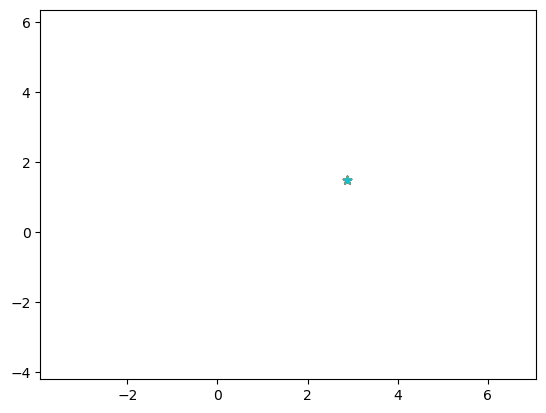

In [328]:
for i in range(20):
    this_res = optimizer.suggest(utility)
    plt.scatter(this_res["PC1"], this_res["PC2"], marker = "*")

plt.xlim(*PC1_pbound)
plt.ylim(*PC2_pbound)
    

In [329]:
res = optimizer.suggest(utility)

res

{'PC1': 2.8683905967738497, 'PC2': 1.4697380123360553}

In [330]:
this_coord = (f"{res['PC1']:.2f}", f"{res['PC2']:.2f}")
print(this_coord)

('2.87', '1.47')


In [331]:
#current max
crt_max = optimizer.max
crt_max_value = crt_max['target']
crt_max_pc1 = crt_max['params']['PC1']
crt_max_pc2 = crt_max['params']['PC2']

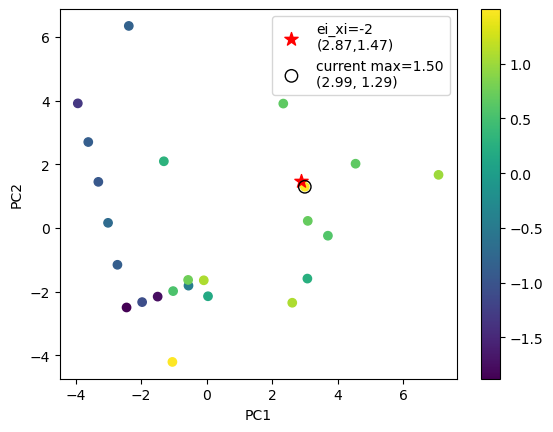

In [332]:
plt.scatter(PC1, PC2, c = Y)
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.scatter(res["PC1"], res["PC2"], marker = "*", s = 100, color = 'r', label = f"{ucb_kappa=}\n({res['PC1']:.2f},{res['PC2']:.2f})")
# plt.scatter(res["PC1"], res["PC2"], marker = "*", s = 100, color = 'r', label = f"poi_{xi=}\n({res['PC1']:.2f},{res['PC2']:.2f})")
plt.scatter(res["PC1"], res["PC2"], marker = "*", s = 100, color = 'r', label = f"ei_{xi=}\n({res['PC1']:.2f},{res['PC2']:.2f})")

plt.scatter(crt_max_pc1, crt_max_pc2, marker = "o", ec = "k", fc = "None", s = 80, label = f"current max={crt_max_value:.2f}\n({crt_max_pc1:.2f}, {crt_max_pc2:.2f})")
plt.legend()
# filename = f"ucb_kappa_{ucb_kappa:.2f}.png"
# filename = f"poi_xi_{xi:.2f}.png"
filename = f"ei_xi_{xi:.2f}.png"
plt.savefig(filename)

In [333]:
# all_kappa = np.linspace(0, 1, 21)

# for i in range(20):
#     this_kappa = all_kappa[i]
#     this_utility = UtilityFunction(kind="ucb", kappa=this_kappa, xi=0.0)
#     this_res = optimizer.suggest(this_utility)
#     plt.scatter(this_res["PC1"], this_res["PC2"],s = i*10, marker = "*")

# plt.xlim(*PC1_pbound)
# plt.ylim(*PC2_pbound)

In [334]:
optimizer.max

{'target': 1.4984287460757888,
 'params': {'PC1': 2.993403898202905, 'PC2': 1.2924838270266477}}

Now we try to plot the utility function

First we create the x's 

we select 100 points

In [335]:
Xpc1, Xpc2 = np.mgrid[PC1_pbound[0]:PC1_pbound[1]:101j, PC2_pbound[0]:PC2_pbound[1]:101j]

In [336]:
#flatten the 2D array into 1D

In [337]:
xpc = [ [xpc1, xpc2] for xpc1, xpc2 in zip(Xpc1.flatten(), Xpc2.flatten())]

In [338]:
#extract the utility function and calculate each value of utility function for linspaced x's

In [339]:
util_flat = utility.utility(xpc, optimizer._gp, optimizer.max['target'])

In [340]:
#and reshape into 2D, with same number of points as the meshgrid

In [341]:
util = util_flat.reshape(101,101)

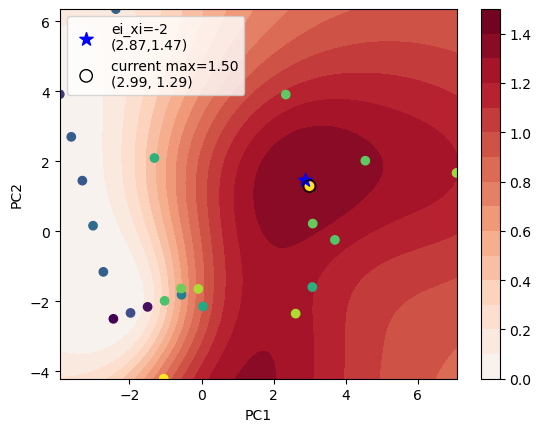

In [342]:
from matplotlib.colors import CenteredNorm
# plt.pcolor(Xpc1, Xpc2, util, cmap='RdBu_r', norm=CenteredNorm())
plt.contourf(Xpc1, Xpc2, util, 15, cmap='RdBu_r', norm=CenteredNorm())
plt.colorbar()

plt.scatter(PC1, PC2, c = Y)
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.scatter(res["PC1"], res["PC2"], marker = "*", color = 'b', s = 100, label = f"{ucb_kappa=}\n({res['PC1']:.2f},{res['PC2']:.2f})")
# plt.scatter(res["PC1"], res["PC2"], marker = "*", s = 100, color = 'b', label = f"poi_{xi=}\n({res['PC1']:.2f},{res['PC2']:.2f})")
plt.scatter(res["PC1"], res["PC2"], marker = "*", s = 100, color = 'b', label = f"ei_{xi=}\n({res['PC1']:.2f},{res['PC2']:.2f})")

plt.scatter(crt_max_pc1, crt_max_pc2, marker = "o", ec = "k", fc = "None", s = 80, label = f"current max={crt_max_value:.2f}\n({crt_max_pc1:.2f}, {crt_max_pc2:.2f})")

plt.legend()

# filename = f"ucb_kappa_{ucb_kappa:.2f}_cplot.png"
# filename = f"poi_xi_{xi:.2f}_cplot.png"
filename = f"ei_xi_{xi:.2f}_cplot.png"

plt.savefig(filename)